# Figure A2
Particle-size distributions. These are created using the *faamasd* library, developed for this paper. Currently, this can be installed using pip via github, following the instructions in the README.md file.

In [1]:
# Standard Library
import os
from glob import glob
import datetime as dt

# Others
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import matplotlib as mpl

import warnings
warnings.simplefilter("ignore", category=FutureWarning) # for FutureWarning only

import faamasd as asd

In [2]:
base = '/home/users/erinraif/acao_data/probe_calibration/'

In [3]:
pcasp_scattering_inputs = asd.pcasp_scattering_inputs
cdp_scattering_inputs = asd.cdp_scattering_inputs
cdp_channel_data_folder = base + 'channel_data_CDP'
pcasp_channel_data_folder = base + 'channel_data_PCASP'
attribute_file = base + 'attributes_for_calibration_arrays.txt' # Set to None if not present

In [4]:
pcasp_calibration = asd.produce_calibration_dataset(pcasp_channel_data_folder,pcasp_scattering_inputs,
                                                    attribute_file)
cdp_calibration = asd.produce_calibration_dataset(cdp_channel_data_folder,cdp_scattering_inputs,attribute_file)

In [5]:
pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = 1.56+0j)
cdp_cal_at_ri = cdp_calibration.sel(refractive_index = 1.56+0j)


In [6]:
timings_data = pd.read_csv(
    '/home/users/erinraif/acao_data/metadata/timings_of_filter_legs_acao.csv',
    index_col='unique_ID')
timings_data = timings_data[timings_data['psd_available'] == True]
timings_data = timings_data.drop(['c276r3t','c278r3t'])

In [7]:
leg_types = pd.read_csv('/home/users/erinraif/acao_data/metadata/filter_leg_types.csv',
                        index_col='unique_ID')

In [8]:
def get_timings(metadata_row):
    """Retrieve filter run timings, including pauses.
    
    Returns a list of consecutive times as ints in SPM. This is in the format
    [start, (pause1 start), (pause1 end), ..., end]
    where pauses are only present where necessary.
    
    Parameters
    ----------
    metadata_row: pandas Series
        row of the metadata pandas dataframe
    
    Returns
    -------
    list of ints
        times in SPM of run events
    """
    leg_start_times = [metadata_row.start_time]
    leg_end_times = [metadata_row.end_time]
    pauses = metadata_row.no_pauses
    for i in range(pauses):
        start_str = 'metadata_row.pause' + str(i+1) + '_end'
        end_str = 'metadata_row.pause' + str(i+1) + '_start'
        leg_start_times.append(eval(start_str))
        leg_end_times.insert(i, eval(end_str))
    return leg_start_times, leg_end_times

In [9]:
def custom_formatter(x, pos):
    if x < 1:
        return "{:.1f}".format(x)
    else:
        return int(x)


In [10]:
def get_linestyle(count, colors, lines):
    # function ensures that (consistent) different linestyles are maintained
    c = colors[count % len(colors)]
    ls = lines[count // len(colors)]
    return ls, c
default_colors = mcolors.TABLEAU_COLORS
colors = list(default_colors.keys())
lines=['solid','dotted',(0,(5,1))]

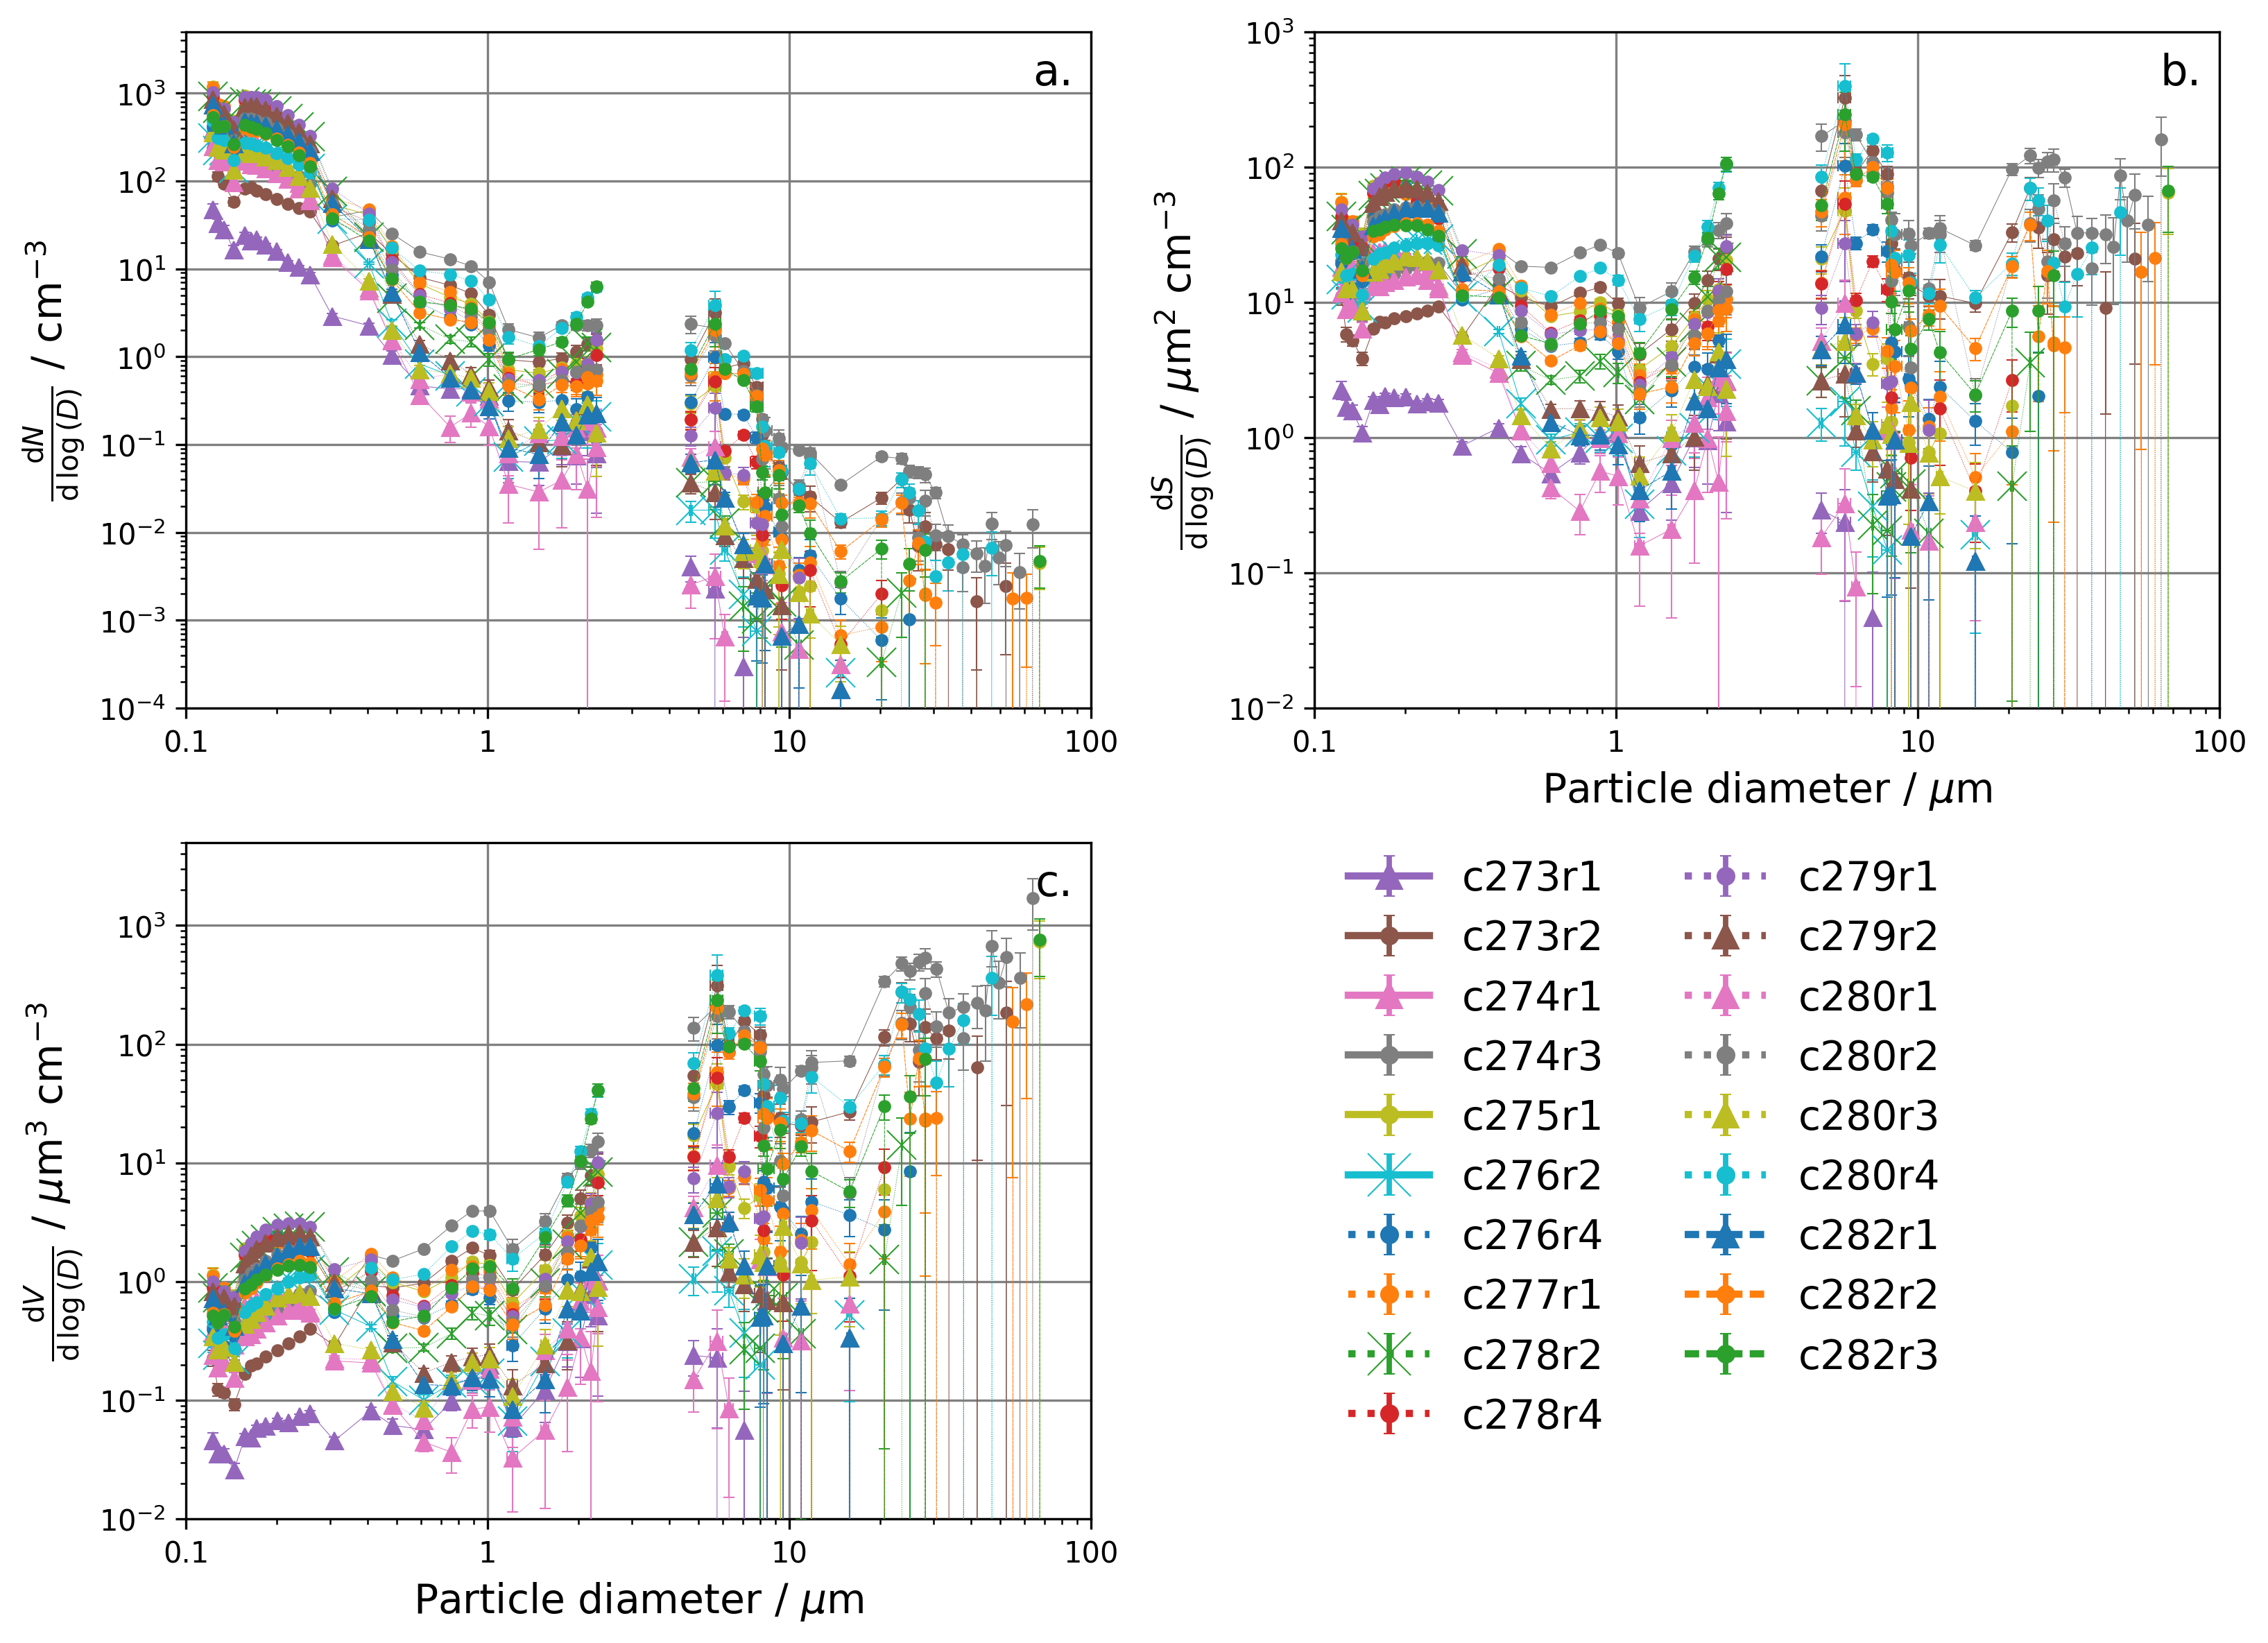

In [11]:
fig, ((dN_ax, dS_ax), (dV_ax, dud_ax)) = plt.subplots(nrows=2,ncols=2,dpi=300,figsize=(11,8))
kwargs = dict(linewidth=0.25,marker='o',elinewidth=0.5,markersize=2,capsize=2,
              markeredgewidth=0.5,capthick=0.25,xlim=[0.1,100],ylim=[1e-4,1e3],
              xlabel=None,zorder=4)
# use same linestyle system as fig03
line_count = 4
for run in timings_data.itertuples():
    if leg_types.loc[run.Index]['type'] == 'below':
        m = 'o'
        ms = 4
    elif leg_types.loc[run.Index]['type'] == 'above':
        m = '^'
        ms = 6
    elif leg_types.loc[run.Index]['type'] == 'upstream':
        m = 'x'
        ms = 10
    ls, c = get_linestyle(line_count, colors, lines)
    line_count += 1
    kwargs['marker']=m
    kwargs['markersize']=ms
    kwargs['color']=c
    kwargs['linestyle']=ls
    # Get FAAM data for the run
    core_cloud_data_fn = glob(os.path.join(
        '/badc/faam/data/2022',run.flight + '*/core_processed',run.core_cloud
    ))[0]
    core_data_fn = glob(os.path.join(
        '/badc/faam/data/2022',run.flight + '*/core_processed',run.core_faam
    ))[0]
    nev_data_fn = '/home/users/erinraif/acao_data/nevzorov_data/' + run.nev_data
    flight_data = asd.get_data(core_cloud_data_fn, core_data_fn)
    # Get Nevzorov dataset provided by Steve Abel
    nev_ds = xr.open_dataset(nev_data_fn, engine='netcdf4',decode_times=False)
    nev_ds = nev_ds.rename_dims({'TIME': 'time'})
    nev_ds = nev_ds.rename({'TIME': 'time'})
    nev_flag = nev_ds.CLRFLG_COMBINED
    # Slice data to runtime and get PSD-data
    leg_start_times, leg_end_times = get_timings(run)
    nev_flag = asd.time_slice_data(leg_start_times, leg_end_times, nev_flag)
    uncorrected_pcasp, corrected_pcasp, pcasp_flow = asd.get_pcasp_data_for_leg(flight_data, leg_start_times, leg_end_times)
    pcasp_psds = asd.get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp, corrected_pcasp, pcasp_flow, bin_merging=True)
    uncorrected_cdp, corrected_cdp, cdp_flow = asd.get_cdp_data_for_leg(flight_data, leg_start_times, leg_end_times)
    rh_liq = asd.time_slice_data(leg_start_times, leg_end_times, flight_data['RH_LIQ'])
    # Apply masks for relative humidity and being in-cloud and get calibrated PSDSs
    try:
        rh_mask = rh_liq < 80
        nev_mask = nev_flag > 0.5
        comb_mask = rh_mask & nev_mask
        comb_uncorrected_cdp = uncorrected_cdp.where(comb_mask,drop=True)
        comb_corrected_cdp = corrected_cdp.where(comb_mask, drop=True)
        comb_cdp_psds = asd.get_mean_log_psds(cdp_cal_at_ri, comb_uncorrected_cdp, comb_corrected_cdp, cdp_flow)
        dN, dS, dV, dN_err, dS_err, dV_err = asd.integrate_distribution_with_errors(pcasp_psds, comb_cdp_psds)
        df_row = dict(
            run_ID = str(run.Index),
            cdp_assump = 'both',
            dN = dN,
            dS = dS,
            dV = dV,
            dN_err = dN_err,
            dS_err = dS_err,
            dV_err = dV_err
        )
        dN_ax = asd.plot_dNdlogD(dN_ax, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        dS_ax = asd.plot_dSdlogD(dS_ax, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        dV_ax = asd.plot_dVdlogD(dV_ax, pcasp_psds.sel(bin=slice(2,29)), False, **kwargs)
        dS_ax = asd.plot_dSdlogD(dS_ax, comb_cdp_psds, False, **kwargs)
        dV_ax = asd.plot_dVdlogD(dV_ax, comb_cdp_psds, False, **kwargs)
        dN_ax = asd.plot_dNdlogD(dN_ax, comb_cdp_psds, False, **kwargs)
        # Add dummy plots to dummy axes
        if ls == (0,(5,1)):
            dud_kwargs = dict(linewidth=2.5,marker=m,elinewidth=0.75*2.5,markersize=ms*1.5,capsize=2,
                              linestyle=(0,(2,1)), color =c, markeredgewidth=0.5,label=run.Index[:-1])
        else:
            dud_kwargs = dict(linewidth=2.5,marker=m,elinewidth=0.75*2.5,markersize=ms*1.5,capsize=2,
                              linestyle = ls, color =c, markeredgewidth=0.5,label=run.Index[:-1])
        
        
        dud_ax.errorbar([0],[0],[0.5], **dud_kwargs)
            
    except:
        print(run.Index, " had no cloud-free sample periods.")
# Set y-limits
dN_ax.set_ylim(1e-4,5e3)
dS_ax.set_ylim(1e-2,1e3)
dV_ax.set_ylim(1e-2,5e3)

dN_ax.text(0.98, 0.97, 'a.', ha='right', va='top', fontsize=15,
           transform=dN_ax.transAxes)
dS_ax.text(0.98, 0.97, 'b.', ha='right', va='top', fontsize=15,
           transform=dS_ax.transAxes)
dV_ax.text(0.98, 0.97, 'c.', ha='right', va='top', fontsize=15,
           transform=dV_ax.transAxes)
dV_ax.set_xlabel(r'Particle diameter / $\mu$m', fontsize=14)
dS_ax.set_xlabel(r'Particle diameter / $\mu$m', fontsize=14)

dN_ax.yaxis.label.set_fontsize(14)
dS_ax.yaxis.label.set_fontsize(14)
dV_ax.yaxis.label.set_fontsize(14)
for ax in (dN_ax, dS_ax, dV_ax):
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(custom_formatter))
    ax.grid(visible=False,which='minor')
# Make dummy axis invisible and add legend
dud_ax.spines['top'].set_visible(False)
dud_ax.spines['right'].set_visible(False)
dud_ax.spines['bottom'].set_visible(False)
dud_ax.spines['left'].set_visible(False)
dud_ax.tick_params(axis='both', which='both', bottom=False, 
                   left=False, labelbottom=False, labelleft=False)
dud_ax.set_xlim(1,2)
dud_ax.set_ylim(1,2)
dud_ax.legend(ncols=2, fontsize=14,loc='upper left',frameon=False,borderaxespad=0,
             bbox_to_anchor=(0.02,1))
fig.tight_layout()
fig.savefig('./imgs/fA2.pdf')